# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

from functions import train_model

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data understanding

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [ ]:
portfolio

In [ ]:
portfolio.info()

In [ ]:
portfolio['channels'].explode().unique()

In [ ]:
portfolio['id']

In [4]:
port_id = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'ofr_A',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'ofr_B',
    '3f207df678b143eea3cee63160fa8bed': 'ofr_C',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'ofr_D',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'ofr_E',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'ofr_F',
    'fafdcd668e3743c1bb461111dcafc2a4': 'ofr_G',
    '5a8bc65990b245e5a138643cd4eb9837': 'ofr_H',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'ofr_I',
    '2906b810c7d4411798c6938adc9daaa5': 'ofr_J'
}


portfolio['id_short'] = portfolio['id'].map(port_id)

In [ ]:
portfolio

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [ ]:
profile.head()

In [ ]:
profile.info()

In [ ]:
profile.describe(include='all')

In [ ]:
profile['gender'].value_counts(dropna=False)

In [ ]:
profile['age'].describe(include='all')

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [ ]:
transcript.head()

In [ ]:
transcript.info()

In [22]:
#transcript.describe(include='all')

In [ ]:
transcript['value']

In [ ]:
transcript['event'].unique()

In [9]:
transcript['event'] = transcript['event'].str.replace(' ','_')

In [10]:
def fix_offer_id(value):
    if isinstance(value, dict) and 'offer id' in value:
        value['offer_id'] = value.pop('offer id')
    return value

transcript['value'] = transcript['value'].apply(fix_offer_id)

In [ ]:
set([list(x.keys())[0] for x in transcript['value']])

In [11]:
value_df = pd.json_normalize(transcript['value']).fillna(0)
value_df['offer_id'] = value_df['offer_id'].map(port_id).fillna('tran')
transcript_b = pd.concat([transcript, value_df], axis=1).drop('value', axis=1)

In [108]:
#transcript_recieved = transcript_b[transcript_b['event'] == 'offer_received'].copy()
#transcript_completed = transcript_b[transcript_b['event'] == 'offer_completed'].copy()
#transcript_transaction = transcript_b[transcript_b['event'] == 'transaction'].copy()
#transcript_viewd = transcript_b[transcript_b['event'] == 'offer_viewed'].copy()
#transcript_event = transcript_b[transcript_b['event'] != 'transaction'].copy()

In [14]:
transcript_b

,person,event,time,offer_id,amount,reward,tag
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,ofr_D,0.00,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,ofr_E,0.00,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,ofr_J,0.00,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,ofr_G,0.00,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,ofr_B,0.00,0.0,0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,tran,1.59,0.0,13
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,tran,9.53,0.0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,tran,3.61,0.0,19
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,tran,3.53,0.0,12


In [130]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,id_short
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,ofr_A
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,ofr_B
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,ofr_C
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,ofr_D
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,ofr_E
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,ofr_F
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,ofr_G
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,ofr_H
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,ofr_I
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,ofr_J


In [118]:
transcript_b['tag'] = (
    transcript_b.groupby(['person', 'event', 'offer_id'])
    .cumcount()
)


person_activity = transcript_b[transcript_b['event'] != 'transaction'].pivot_table(
    index=['person', 'offer_id', 'tag'], 
    columns='event',
    values='time', 
    margins=False, 
    dropna=True,
    #fill_value=0
    ).reset_index()

person_activity['ofr_influence'] = person_activity['offer_completed'] >= person_activity['offer_viewed'] 
person_activity['extrm_ofr_influence'] = person_activity['offer_completed'] == person_activity['offer_viewed']
person_activity['fidelity_vr'] = person_activity['offer_viewed'] - person_activity['offer_received']
person_activity['fidelity_cv'] = person_activity['offer_completed'] - person_activity['offer_viewed']
person_activity['overal_cr'] = person_activity['offer_completed'] - person_activity['offer_received']

#person_activity['n_tran'] = transcript_b['enevnt']

person_activity

event,person,offer_id,tag,offer_completed,offer_received,offer_viewed,ofr_influence,extrm_ofr_influence,fidelity_vr,fidelity_cv,overal_cr
0,0009655768c64bdeb2e877511632db8f,ofr_C,0,NaN,336.0,372.0,False,False,36.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,ofr_G,0,528.0,504.0,540.0,False,False,36.0,-12.0,24.0
2,0009655768c64bdeb2e877511632db8f,ofr_H,0,NaN,168.0,192.0,False,False,24.0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,ofr_I,0,414.0,408.0,456.0,False,False,48.0,-42.0,6.0
4,0009655768c64bdeb2e877511632db8f,ofr_J,0,576.0,576.0,NaN,False,False,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,0,198.0,168.0,174.0,True,False,6.0,24.0,30.0
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,0,60.0,0.0,6.0,True,False,6.0,54.0,60.0
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,0,384.0,336.0,354.0,True,False,18.0,30.0,48.0
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,1,414.0,408.0,414.0,True,True,6.0,0.0,6.0


In [47]:
transcript_b

,person,event,time,offer_id,amount,reward,tag
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,0,ofr_D,0.00,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer_received,0,ofr_E,0.00,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer_received,0,ofr_J,0.00,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,0,ofr_G,0.00,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer_received,0,ofr_B,0.00,0.0,0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,tran,1.59,0.0,13
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,tran,9.53,0.0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,tran,3.61,0.0,19
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,tran,3.53,0.0,12


In [85]:
transcript_b['time'].max()

np.int64(714)

In [119]:
grouped1 = transcript_b[transcript_b['event'] == 'transaction'].groupby(['person', 'offer_id'])
grouped2 = transcript_b[transcript_b['event'] == 'offer_completed'].groupby(['person', 'offer_id'])

aggregations1 = grouped1.agg(
    fidelity=('event', 'count'),
    last_time_tr=('time', 'max')
).reset_index()

aggregations2 = grouped2.agg(
    first_comp =('time', 'min'), 
    last_comp =('time', 'max') 

).reset_index()

fidelity = pd.merge(
    how='left',
    left=aggregations1,
    right=aggregations2,
    on=['person']
)

fidelity['time_to_end'] = transcript_b['time'].max() - fidelity['last_comp']

fidelity

,person,offer_id_x,fidelity,last_time_tr,offer_id_y,first_comp,last_comp,time_to_end
0,0009655768c64bdeb2e877511632db8f,tran,8,696,ofr_G,528.0,528.0,186.0
1,0009655768c64bdeb2e877511632db8f,tran,8,696,ofr_I,414.0,414.0,300.0
2,0009655768c64bdeb2e877511632db8f,tran,8,696,ofr_J,576.0,576.0,138.0
3,00116118485d4dfda04fdbaba9a87b5c,tran,3,474,NaN,NaN,NaN,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,tran,5,654,ofr_D,576.0,576.0,138.0
...,...,...,...,...,...,...,...,...
32795,fffad4f4828548d1b5583907f2e9906b,tran,12,678,ofr_I,36.0,516.0,198.0
32796,ffff82501cea40309d5fdd7edcca4a07,tran,15,648,ofr_D,504.0,504.0,210.0
32797,ffff82501cea40309d5fdd7edcca4a07,tran,15,648,ofr_E,198.0,198.0,516.0
32798,ffff82501cea40309d5fdd7edcca4a07,tran,15,648,ofr_G,60.0,60.0,654.0


In [115]:
fidelity[fidelity['person'] == '0009655768c64bdeb2e877511632db8f']

,person,offer_id_x,fidelity,last_time_tr,offer_id_y,first_comp,last_comp,time_to_end
0,0009655768c64bdeb2e877511632db8f,tran,8,696,ofr_G,528.0,528.0,186.0
1,0009655768c64bdeb2e877511632db8f,tran,8,696,ofr_I,414.0,414.0,300.0
2,0009655768c64bdeb2e877511632db8f,tran,8,696,ofr_J,576.0,576.0,138.0


In [116]:
transcript_b[transcript_b['person'] == '0009655768c64bdeb2e877511632db8f']

,person,event,time,offer_id,amount,reward,tag
55972,0009655768c64bdeb2e877511632db8f,offer_received,168,ofr_H,0.00,0.0,0
77705,0009655768c64bdeb2e877511632db8f,offer_viewed,192,ofr_H,0.00,0.0,0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,tran,22.16,0.0,0
113605,0009655768c64bdeb2e877511632db8f,offer_received,336,ofr_C,0.00,0.0,0
139992,0009655768c64bdeb2e877511632db8f,offer_viewed,372,ofr_C,0.00,0.0,0
153401,0009655768c64bdeb2e877511632db8f,offer_received,408,ofr_I,0.00,0.0,0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,tran,8.57,0.0,1
168413,0009655768c64bdeb2e877511632db8f,offer_completed,414,ofr_I,0.00,5.0,0
187554,0009655768c64bdeb2e877511632db8f,offer_viewed,456,ofr_I,0.00,0.0,0
204340,0009655768c64bdeb2e877511632db8f,offer_received,504,ofr_G,0.00,0.0,0


In [120]:
transcript_transaction = transcript_b[transcript_b['event'] == 'transaction'].copy()

person_activity_tran = pd.merge(
    how='left', left=person_activity,
    right=transcript_transaction,
    left_on=['person', 'offer_completed'], 
    right_on=['person', 'time']
    ).drop(columns=['event', 'time',	'offer_id_y',	'reward',	'tag_y', 'tag_x'])

person_activity_tran['amount'] = person_activity_tran['amount'].fillna(0)

person_activity_tran = pd.merge(
    how='left',
    left=person_activity_tran,
    right=profile,
    left_on='person',
    right_on='id'
).drop(columns=['id'])

person_activity_tran = pd.merge(
    how='left',
    left=person_activity_tran,
    right=fidelity,
    left_on=['person', 'offer_id_x'],
    right_on=['person', 'offer_id_y']
)

#person_activity_tran = person_activity_tran

person_activity_tran

,person,offer_id_x_x,offer_completed,offer_received,offer_viewed,ofr_influence,extrm_ofr_influence,fidelity_vr,fidelity_cv,overal_cr,...,age,became_member_on,income,offer_id_x_y,fidelity,last_time_tr,offer_id_y,first_comp,last_comp,time_to_end
0,0009655768c64bdeb2e877511632db8f,ofr_C,NaN,336.0,372.0,False,False,36.0,NaN,NaN,...,33,20170421,72000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,ofr_G,528.0,504.0,540.0,False,False,36.0,-12.0,24.0,...,33,20170421,72000.0,tran,8.0,696.0,ofr_G,528.0,528.0,186.0
2,0009655768c64bdeb2e877511632db8f,ofr_H,NaN,168.0,192.0,False,False,24.0,NaN,NaN,...,33,20170421,72000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,ofr_I,414.0,408.0,456.0,False,False,48.0,-42.0,6.0,...,33,20170421,72000.0,tran,8.0,696.0,ofr_I,414.0,414.0,300.0
4,0009655768c64bdeb2e877511632db8f,ofr_J,576.0,576.0,NaN,False,False,NaN,NaN,0.0,...,33,20170421,72000.0,tran,8.0,696.0,ofr_J,576.0,576.0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,198.0,168.0,174.0,True,False,6.0,24.0,30.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_E,198.0,198.0,516.0
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,60.0,0.0,6.0,True,False,6.0,54.0,60.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_G,60.0,60.0,654.0
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,384.0,336.0,354.0,True,False,18.0,30.0,48.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_J,384.0,576.0,138.0
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,414.0,408.0,414.0,True,True,6.0,0.0,6.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_J,384.0,576.0,138.0


In [136]:
person_activity_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               76277 non-null  object 
 1   offer_id_x_x         76277 non-null  object 
 2   offer_completed      33579 non-null  float64
 3   offer_received       76277 non-null  float64
 4   offer_viewed         57725 non-null  float64
 5   ofr_influence        76277 non-null  bool   
 6   extrm_ofr_influence  76277 non-null  bool   
 7   fidelity_vr          57725 non-null  float64
 8   fidelity_cv          27950 non-null  float64
 9   overal_cr            33579 non-null  float64
 10  amount               76277 non-null  float64
 11  gender               66501 non-null  object 
 12  age                  76277 non-null  int64  
 13  became_member_on     76277 non-null  int64  
 14  income               66501 non-null  float64
 15  offer_id_x_y         35997 non-null 

<Axes: xlabel='offer_completed,offer_id_x_x'>

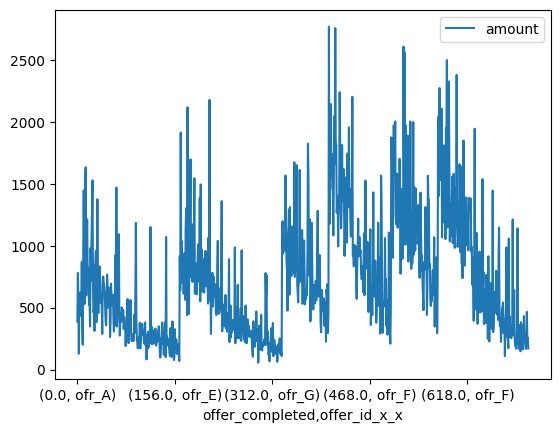

In [138]:
grouped = person_activity_tran.groupby(['offer_completed', 'offer_id_x_x'])

aggregations = grouped.agg(
    amount=('amount', 'sum'),
)

aggregations.plot()

In [139]:
aggregations

amount
offer_completed offer_id_x_x        
0.0             ofr_A         388.30
                ofr_B         780.84
                ofr_D         564.37
                ofr_E         128.67
                ofr_F         580.73
...                              ...
714.0           ofr_D         253.33
                ofr_E         466.65
                ofr_F         252.04
                ofr_G         257.25
                ofr_J         170.91

[926 rows x 1 columns]

In [105]:
person_activity_tran[person_activity_tran['person'] == 'ffff82501cea40309d5fdd7edcca4a07']

,person,offer_id_x_x,offer_completed,offer_received,offer_viewed,ofr_influence,extrm_ofr_influence,fidelity_viw,fidelity_comp,overal_fidelity,...,age,became_member_on,income,offer_id_x_y,fidelity,last_time_tr,offer_id_y,first_comp,last_comp,time_to_end
76271,ffff82501cea40309d5fdd7edcca4a07,ofr_D,504.0,504.0,534.0,False,False,30.0,0.0,0.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_D,504.0,504.0,210.0
76272,ffff82501cea40309d5fdd7edcca4a07,ofr_E,198.0,168.0,174.0,True,False,6.0,30.0,30.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_E,198.0,198.0,516.0
76273,ffff82501cea40309d5fdd7edcca4a07,ofr_G,60.0,0.0,6.0,True,False,6.0,60.0,60.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_G,60.0,60.0,654.0
76274,ffff82501cea40309d5fdd7edcca4a07,ofr_J,384.0,336.0,354.0,True,False,18.0,48.0,48.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_J,384.0,576.0,138.0
76275,ffff82501cea40309d5fdd7edcca4a07,ofr_J,414.0,408.0,414.0,True,True,6.0,6.0,6.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_J,384.0,576.0,138.0
76276,ffff82501cea40309d5fdd7edcca4a07,ofr_J,576.0,576.0,582.0,False,False,6.0,0.0,0.0,...,45,20161125,62000.0,tran,15.0,648.0,ofr_J,384.0,576.0,138.0


In [123]:
# Realizando o agrupamento uma única vez
grouped = person_activity_tran.groupby('offer_id_x_x')

# Calculando todas as métricas necessárias
aggregations = grouped.agg(
    tot_ofr=('ofr_influence', 'count'),
    tot_amt=('amount', 'sum'),
    avr_amt=('amount', 'mean'),
    influ=('ofr_influence', 'sum'),
    ex_influ=('extrm_ofr_influence', 'sum'),
    ofr_inf_rate=('ofr_influence', 'mean'),
    ex_inf_rate=('extrm_ofr_influence', 'mean')

).reset_index()

# Arredondando os valores para 2 casas decimais
result = aggregations.round(2)

result['ext_prop'] = result['ex_influ']/result['influ']  

offer_summary = pd.merge(
    how='left', 
    left=result,
    right=portfolio,
    left_on=['offer_id_x_x'], 
    right_on=['id_short'],
    
    ).drop(columns=['id','id_short'])


offer_summary = offer_summary.fillna(0)

offer_summary


,offer_id_x_x,tot_ofr,tot_amt,avr_amt,influ,ex_influ,ofr_inf_rate,ex_inf_rate,ext_prop,reward,channels,difficulty,duration,offer_type
0,ofr_A,7658,88106.63,11.51,2629,332,0.34,0.04,0.126284,10,"[email, mobile, social]",10,7,bogo
1,ofr_B,7593,79283.59,10.44,2788,375,0.37,0.05,0.134505,10,"[web, email, mobile, social]",10,5,bogo
2,ofr_C,7617,0.00,0.00,0,0,0.00,0.00,0.000000,0,"[web, email, mobile]",0,4,informational
3,ofr_D,7677,77911.04,10.15,2125,269,0.28,0.04,0.126588,5,"[web, email, mobile]",5,7,bogo
4,ofr_E,7668,87898.52,11.46,1311,79,0.17,0.01,0.060259,5,"[web, email]",20,10,discount
5,ofr_F,7646,90552.42,11.84,4392,457,0.57,0.06,0.104053,3,"[web, email, mobile, social]",7,7,discount
6,ofr_G,7597,97892.24,12.89,4664,415,0.61,0.05,0.088979,2,"[web, email, mobile, social]",10,10,discount
7,ofr_H,7618,0.00,0.00,0,0,0.00,0.00,0.000000,0,"[email, mobile, social]",0,3,informational
8,ofr_I,7571,83592.17,11.04,3559,494,0.47,0.07,0.138803,5,"[web, email, mobile, social]",5,5,bogo
9,ofr_J,7632,82688.83,10.83,2111,206,0.28,0.03,0.097584,2,"[web, email, mobile]",10,7,discount


In [127]:
grouped = person_activity_tran.groupby(['gender', 'offer_id_x_x'])

# Calculando todas as métricas necessárias
aggregations = grouped.agg(
    ofr_inf_sum=('ofr_influence', 'sum'),
    ex_inf_sum=('extrm_ofr_influence', 'sum'),
    ofr_inf_rate=('ofr_influence', 'mean'),
    ex_inf_rate=('extrm_ofr_influence', 'mean'),
    amt_sum=('amount', 'sum'),
    amt_mean=('amount', 'mean'),
    ofr_inf_cnt=('ofr_influence', 'count')
).reset_index()

# Arredondando os valores para 2 casas decimais
result = aggregations.round(2)

result

,gender,offer_id_x_x,ofr_inf_sum,ex_inf_sum,ofr_inf_rate,ex_inf_rate,amt_sum,amt_mean,ofr_inf_cnt
0,F,ofr_A,1304,153,0.47,0.06,44068.54,16.02,2750
1,F,ofr_B,1468,207,0.54,0.08,41733.87,15.25,2737
2,F,ofr_C,0,0,0.00,0.00,0.00,0.00,2749
3,F,ofr_D,926,128,0.33,0.05,40333.74,14.58,2767
4,F,ofr_E,602,45,0.21,0.02,45620.03,16.29,2801
5,F,ofr_F,1820,222,0.67,0.08,47394.95,17.44,2718
6,F,ofr_G,1913,236,0.71,0.09,45808.62,16.99,2696
7,F,ofr_H,0,0,0.00,0.00,0.00,0.00,2789
8,F,ofr_I,1574,233,0.58,0.09,43804.99,16.10,2721
9,F,ofr_J,896,95,0.33,0.03,38913.61,14.26,2728


In [234]:
def categorize_age(age):
    if age < 25:
        return 'Young Adult'
    elif 25 <= age < 40:
        return 'Adult'
    elif 40 <= age < 60:
        return 'Middle-Aged'
    else:
        return 'Senior'

# Aplicar a função ao DataFrame
tb_transactions['age_segment'] = tb_transactions['age'].apply(categorize_age)

In [38]:
#df = df.dropna()

X = df.drop(columns = ['person', 'event', 'became_member_on', 'gender', 'income'])
y = df['gender']

In [ ]:
y.value_counts()

In [ ]:
model1 = RandomForestClassifier(
    random_state=42,
    max_depth=15,
    n_estimators=25,
    min_samples_leaf=2,
    min_samples_split=2,
    #max_features=0.5,
    n_jobs=-1    
    )

model2 = DecisionTreeClassifier(
    random_state=42,
    criterion='entropy',            # Função de impureza para divisão ('gini' ou 'entropy')
    max_depth=15,                # Profundidade máxima da árvore (controle de overfitting)
    min_samples_split=2,         # Número mínimo de amostras para dividir um nó
    min_samples_leaf=2,          # Número mínimo de amostras em uma folha
    #max_features=5,           # Número máximo de features consideradas em cada divisão
    #splitter='random'            # Estratégia para escolher a divisão ('best' ou 'random')
    )



In [ ]:
model_type = model2
train_model(X, y, model_type)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Instanciar o modelo
rf = RandomForestClassifier(random_state=42)

# Definir a grade de parâmetros
param_grid = {
    'n_estimators': [50, 100, 200],         # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],       # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],       # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],         # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2'],      # Número de recursos considerados para divisão
    'bootstrap': [True, False]             # Amostragem com ou sem reposição
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                  # Validação cruzada (5-fold)
    scoring='accuracy',    # Métrica de avaliação
    verbose=2,             # Nível de detalhe das mensagens
    n_jobs=-1              # Paralelização (usar todos os núcleos disponíveis)
)

# Ajustar o modelo aos dados de treino
grid_search.fit(X_train, y_train)

# Exibir os melhores parâmetros e a melhor pontuação
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação (treino):", grid_search.best_score_)

# Avaliar o modelo com os melhores parâmetros nos dados de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste:", test_accuracy)


y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

# 1. Confusion Matrix
cm1 = confusion_matrix(y_train, y_pred_train)
cm2 = confusion_matrix(y_test, y_pred)


# 2. Relatório com Precision, Recall e F1-Score
report1 = classification_report(y_test, y_pred, target_names=best_model.classes_, zero_division=1)
print("Test Classification Report:")
print(report1)

report2 = classification_report(y_train, y_pred_train, target_names=best_model.classes_, zero_division=1)
print("Train Classification Report:")
print(report2)